In [2]:
!pip install Flask
!pip install matplotlib
!pip install numpy
!pip install sqlalchemy

In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"The most recent date in the dataset is: {most_recent_date[0]}")

The most recent date in the dataset is: 2017-08-23


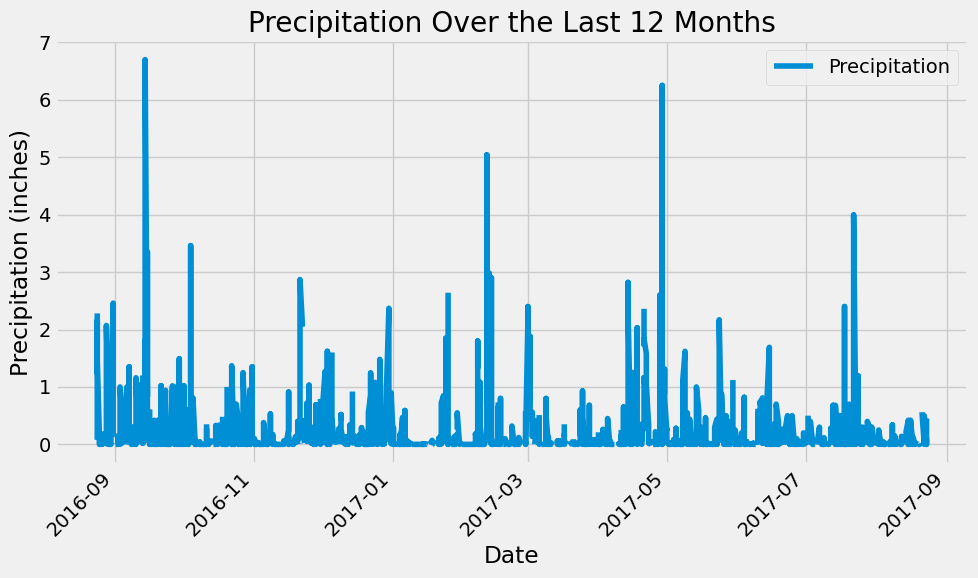

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in the dataset.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', title='Precipitation Over the Last 12 Months', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

print(summary_statistics)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(Station.station))).scalar()

print(f'The total number of stations in the dataset is: {total_stations}')

The total number of stations in the dataset is: 9


In [15]:
# Design a query to find the most active stations (i.e., which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
print("Most active stations:")
for station, count in active_stations:
    print(f"Station {station}: {count} rows")

Most active stations:
Station USC00519281: 2772 rows
Station USC00519397: 2724 rows
Station USC00513117: 2709 rows
Station USC00519523: 2669 rows
Station USC00516128: 2612 rows
Station USC00514830: 2202 rows
Station USC00511918: 1979 rows
Station USC00517948: 1372 rows
Station USC00518838: 511 rows


In [16]:
# Using the most active station id from the previous query
most_active_station = active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Print the results
print(f"Temperature statistics for the most active station (Station {most_active_station}):")
print(f"Lowest Temperature: {temperature_stats[0][0]} °F")
print(f"Highest Temperature: {temperature_stats[0][1]} °F")
print(f"Average Temperature: {round(temperature_stats[0][2], 2)} °F")


Temperature statistics for the most active station (Station USC00519281):
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


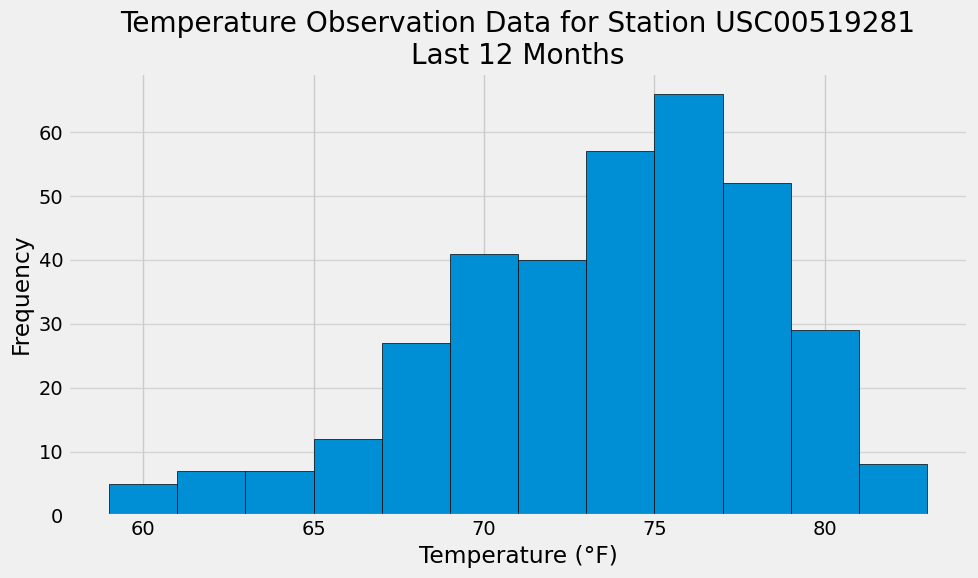

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, edgecolor='black')
plt.title(f'Temperature Observation Data for Station {most_active_station}\nLast 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()



# Close Session

In [18]:
# Close Session
session.close()